### Vehicle Localization with CNNs

In this notebook, we will implement several CNN architectures using Tensorflow, to localize vehicles in traffic camera images.

In [1]:
####Setting up some imports####
##Standard Libraries
import os
import time
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
%matplotlib inline

##Custom
from local_metrics import IOU, metrics
from image_augment import augment
from plot_traffic import plot_traffic
from load_image import load_one_image

In [2]:
##Loading the dataset
data = pickle.load(open("/home/marcchan/Traffic/traffic_image_detection/working_data/working_set.p","rb"))
train_data = data["train_data"]
train_labels = data["train_labels"]
val_data = data["val_data"]
val_labels = data["val_labels"]
del data

In [3]:
num_labels = 2
##convert class_labels to 1-hot encoding
hot_train_labels = (np.arange(num_labels) == train_labels[:,0][:,None]).astype(np.float32)
hot_val_labels = (np.arange(num_labels) == val_labels[:,0][:,None]).astype(np.float32)

In [4]:
##Set up bounding box ground truth labels
train_reg_labels = train_labels[:,1:].astype(np.float32)
val_reg_labels = val_labels[:,1:].astype(np.float32)

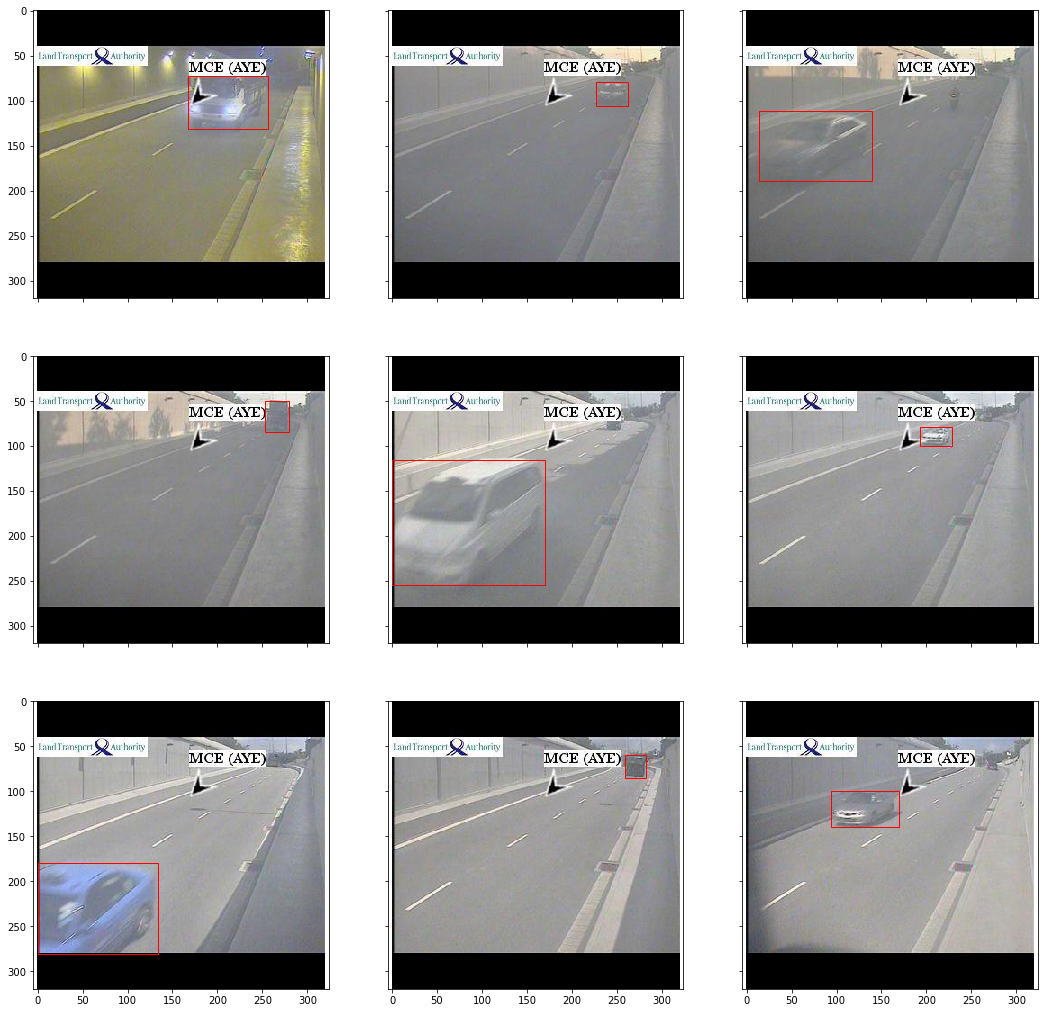

In [5]:
##Plot some images with the localization labels 
plot_traffic(train_data[0:9],train_labels[0:9,1:],train_labels[0:9,0],zero_format=False)

In [5]:
###Building Blocks of the CNN (Convolution, Pooling, Fully Connected) + Batch_Norm
def batch_norm(inputs, is_training,name,decay=0.99):
    with tf.variable_scope("batch_norm"):
        epsilon = 1e-3
        if is_training:
            input_dims = inputs.get_shape().as_list()
            scale = tf.Variable(tf.ones(input_dims[1:]),name="scale")
            beta = tf.Variable(tf.zeros(input_dims[1:]),name="beta")
            pop_mean = tf.Variable(tf.zeros(input_dims[1:]), trainable=False,name="pop_mean")
            pop_var = tf.Variable(tf.ones(input_dims[1:]), trainable=False,name="pop_var")
            if len(input_dims) > 2:
                batch_mean, batch_var = tf.nn.moments(inputs,axes=[0,1,2],keep_dims=False)
            else:
                batch_mean, batch_var = tf.nn.moments(inputs,axes=[0],keep_dims=False)
            train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
            train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,batch_mean, batch_var, beta, scale, epsilon)
        else:
            scale = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/batch_norm/scale:0")
            beta = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/batch_norm/beta:0")
            pop_mean = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/batch_norm/pop_mean:0")
            pop_var = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/batch_norm/pop_var:0")
            return tf.nn.batch_normalization(inputs,pop_mean, pop_var, beta, scale, epsilon)


def conv2d_relu(data,stride,filter_size,output_channels,name,train=True,xv=True):
    with tf.variable_scope(str(name)):
        input_shape = data.get_shape().as_list()
        conv_shape = [filter_size,filter_size,input_shape[-1],output_channels]
        strides = [1,stride,stride,1]
        if train:
            if xv:
                ##Use kaiming-he gaussian initializer, cap between 0.01 - 0.1 for better training
                xv_init = max(min(np.sqrt(2./(filter_size*filter_size*input_shape[-1])),0.1),0.01)
            else:
                xv_init = 0.01
            ##Set up convolution weights and bias
            weights = tf.Variable(tf.truncated_normal(conv_shape,stddev=xv_init),name="weights")
            bias = tf.Variable(tf.zeros([output_channels]),name="bias")
        else:
            weights = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/weights:0")
            bias = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/bias:0")
        ##Set up the convolution model
        conv = tf.nn.conv2d(data,filter=weights,strides=strides,padding="SAME")+bias
        ##RELU activation
        conv_relu = tf.nn.relu(conv,name="RELU")
        ##Batch normalizaton after activation
        conv_norm = batch_norm(conv_relu,name=name,is_training=train)
    return conv_norm

def max_pool(data,pool_size,pool_stride,name):
    with tf.variable_scope(str(name)):
        pool = tf.nn.max_pool(data,[1,pool_size,pool_size,1],[1,pool_stride,pool_stride,1],padding="SAME")
    return pool

def fully_connected(data,output_nodes,name,activation=True,train=True,xv=True):
    with tf.variable_scope(str(name)):
        ##Flatten the data
        data_flat = tf.reshape(data,[data.get_shape().as_list()[0],-1])
        data_flat_shape = data_flat.get_shape().as_list()
        if train:
            if xv:
                ##Use kaiming-he gaussian initializer, cap between 0.01 - 0.1 for better training
                xv_init = max(min(np.sqrt(2./(data_flat_shape[-1])),0.1),0.01)
            else:
                xv_init = 0.01
            ##Set up fully connected weights and bias
            weights = tf.Variable(tf.truncated_normal([data_flat_shape[-1],output_nodes],stddev=xv_init),name="weights")
            bias = tf.Variable(tf.zeros([output_nodes]),name="bias")
        else:
            weights = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/weights:0")
            bias = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/bias:0")
        ##Set up the FC model
        fc = tf.matmul(data_flat,weights)+bias 
        if activation:
            ##Batch normalizaton before activation
            fc_relu = tf.nn.relu(fc,name="RELU")
            #fc_norm = batch_norm(fc_relu,name=name,is_training=train)
            return fc_relu
    return fc

In [6]:
##Define functions to zero-center data and convert zero-centered data back to RGB 255 values
def zero_center(data):
    data = ((data-(255/2))/(255/2)).astype(np.float32)
    return data

def zero_to_rgb(data):
    data = (data*(255/2)+(255/2)).astype(np.uint8)
    return data

In [7]:
##Preprocessing - Zero center the training/validation data
train_data = zero_center(train_data)
val_data = zero_center(val_data)

In [10]:
##The most basic CNN that started it all -- LeNet by Yann LeCun
####Parameters####
image_size = 320
num_channels = 3
num_reg_labels = 4
num_labels = 2
num_hidden = 128
conv_size = 5
conv_stride = 1
pool_size = 2
pool_stride = 2
depth = 18
batch_size = 50
train_epochs = 250
regular_strength = 5e-4
learning_rate = 1e-5
augment_data = True
aug_max_factor = 0.2
#################

graph_lenet_local = tf.Graph()
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local"

with graph_lenet_local.as_default():
    #set up variables/placeholders for tensorflow graph
    with tf.variable_scope("train_input"):
        tf_train_data = tf.placeholder(tf.float32, shape=(batch_size,image_size,image_size,num_channels),name="image_data")
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels),name="class_labels")
        tf_train_reg_labels = tf.placeholder(tf.float32, shape=(batch_size,num_reg_labels),name="bb_labels")
        lr = tf.placeholder(tf.float32,name="learning_rate")
        
    with tf.variable_scope("val_input"):
        tf_val_data = tf.constant(val_data)
        tf_val_labels = tf.constant(hot_val_labels)
        tf_val_reg_labels = tf.constant(val_reg_labels)
        
    
    ##The main CNN model
    def model(data,name,train=True):
        with tf.variable_scope(name):
            conv1 = conv2d_relu(data,conv_stride,conv_size,depth,name="CONV1",train=train)
            pool1 = max_pool(conv1,2,2,name="POOL1")
            conv2 = conv2d_relu(pool1,conv_stride,conv_size,depth,name="CONV2",train=train)
            pool2 = max_pool(conv2,pool_size,pool_stride,name="POOL2")
            fc1_class = fully_connected(pool2,num_hidden,name="FC1_class",train=train)
            output_logits = fully_connected(fc1_class,num_labels,activation=True,name="Output_logits",train=train,xv=False)
            fc1_reg = fully_connected(pool2,num_hidden,name="FC1_reg",train=train)
            output_coords = fully_connected(fc1_reg,num_reg_labels,activation=False,name="Output_coords",train=train,xv=False)
        return output_logits, output_coords
    
    ##Define the loss function
    def loss(reg_pred,reg_label,class_logit,class_label,name):
        with tf.variable_scope(name):
            with tf.variable_scope("Regression_Loss"):
                mask = tf.equal(class_label[:,1], tf.ones_like(class_label[:,1]))
                with tf.variable_scope("Coord_Loss"):
                    coord_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,0:2],mask)-tf.boolean_mask(reg_pred[:,0:2],mask)),1))
                with tf.variable_scope("Box_Loss"):
                    box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,2:],mask)-tf.boolean_mask(reg_pred[:,2:],mask)),1))
                regression_loss = coord_loss + box_loss
            with tf.variable_scope("Class_Loss"):
                class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=class_label,logits=class_logit))
            with tf.variable_scope("Regularization_Loss"):
                g = tf.get_default_graph()
                regular_loss = (tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_class/weights:0"))+ 
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_logits/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_reg/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_coords/weights:0")))
            loss = class_loss+regression_loss+(regular_strength*regular_loss)
        return loss
    
    train_logits, train_coords = model(tf_train_data,"Train_Model",train=True)
    val_logits, val_coords = model(tf_val_data,"Val_Model",train=False)
        
    train_loss = loss(train_coords,tf_train_reg_labels,train_logits,tf_train_labels,"Train_Loss")
    val_loss = loss(val_coords,tf_val_reg_labels,val_logits,tf_val_labels,"Val_Loss")
    
    with tf.variable_scope("Val_Pred_Labels"):
        val_pred_logits = tf.nn.softmax(val_logits)
        val_pred_labels = tf.argmax(val_pred_logits,axis=1)
    
    with tf.variable_scope("Train"):
            train_model = tf.train.AdamOptimizer(lr).minimize(train_loss)
        
    with tf.variable_scope("Saver"):
        saver = tf.train.Saver()
        
print("Tensorflow graph created!")

Tensorflow graph created!


In [11]:
###Training the LeNet Model###
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local"
os.makedirs(save_path,exist_ok=True)
start_time = time.time()

with tf.Session(graph=graph_lenet_local) as sess:
    writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
    val_loss_history = []
    train_loss_history = []
    #tf.global_variables_initializer().run()
    saver.restore(sess, save_path+"/lenet_local_aug.ckpt")
    print("Initialized!")
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        train_epoch_loss = []
        
        ##Data Augmentation (-/+ 20% adjustment on brightness/contrast)
        if augment_data:
            train_data_aug = augment(train_data,aug_max_factor,rand_order=True)
        else:
            train_data_aug = train_data
        
        ##Split into random batches and train
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data_aug[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                lr: learning_rate
            }
            t_loss,_ = sess.run([train_loss,train_model],feed_dict=feed_dict)
            train_epoch_loss.append(t_loss)
        
        ##Calculate validation loss after each epoch
        loss = val_loss.eval()
        val_loss_history.append(loss)
        train_loss_history.append(np.mean(train_epoch_loss))
        print("Epoch {}, train_loss = {},validation loss = {}".format(num_epochs, train_loss_history[-1],loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 50 epochs
        if num_epochs%50 == 0:
            saver.save(sess, save_path+"/lenet_local_aug.ckpt")
            print("Session saved!")
        
        ##Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+"/lenet_local_aug.ckpt")

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

INFO:tensorflow:Restoring parameters from /home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local/lenet_local_aug.ckpt
Initialized!
Epoch 1, train_loss = 0.1822441816329956,validation loss = 0.3486400246620178
IOU: 0.33,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 2, train_loss = 0.18083566427230835,validation loss = 0.34663981199264526
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 3, train_loss = 0.17973345518112183,validation loss = 0.3290866017341614
IOU: 0.34,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Epoch 4, train_loss = 0.17826983332633972,validation loss = 0.31543657183647156
IOU: 0.36,        Accuracy: 0.97,         AUC:0.99,         Precision: 0.98,         Recall: 0.95
Epoch 5, train_loss = 0.17676404118537903,validation loss = 0.3638010621070862
IOU: 0.32,        Accuracy: 0.95,         AUC:0.99,

IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Epoch 47, train_loss = 0.12433004379272461,validation loss = 0.275333046913147
IOU: 0.36,        Accuracy: 0.97,         AUC:0.99,         Precision: 0.99,         Recall: 0.95
Epoch 48, train_loss = 0.12347434461116791,validation loss = 0.2636951804161072
IOU: 0.35,        Accuracy: 0.97,         AUC:0.99,         Precision: 0.99,         Recall: 0.95
Epoch 49, train_loss = 0.12225274741649628,validation loss = 0.2792041301727295
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.96,         Recall: 0.95
Epoch 50, train_loss = 0.12129683792591095,validation loss = 0.2858441472053528
IOU: 0.35,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Session saved!
Epoch 51, train_loss = 0.12036600708961487,validation loss = 0.2853086292743683
IOU: 0.35,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.9

IOU: 0.36,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.96,         Recall: 0.93
Epoch 93, train_loss = 0.08732570707798004,validation loss = 0.24781379103660583
IOU: 0.34,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.95,         Recall: 0.95
Epoch 94, train_loss = 0.09348838031291962,validation loss = 0.8399762511253357
IOU: 0.35,        Accuracy: 0.86,         AUC:0.96,         Precision: 0.80,         Recall: 0.97
Epoch 95, train_loss = 0.18130391836166382,validation loss = 0.6315767765045166
IOU: 0.36,        Accuracy: 0.89,         AUC:0.98,         Precision: 1.00,         Recall: 0.77
Epoch 96, train_loss = 0.09820286929607391,validation loss = 0.23290908336639404
IOU: 0.34,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.97,         Recall: 0.95
Epoch 97, train_loss = 0.08624650537967682,validation loss = 0.22908806800842285
IOU: 0.36,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.96,         Recall: 0.93
Epoch 98,

IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 139, train_loss = 0.07438632100820541,validation loss = 0.2446141242980957
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 140, train_loss = 0.07431948184967041,validation loss = 0.241085022687912
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 141, train_loss = 0.07398702949285507,validation loss = 0.24301362037658691
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 142, train_loss = 0.0736040249466896,validation loss = 0.2435166835784912
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 143, train_loss = 0.0733799934387207,validation loss = 0.2420717477798462
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 144

IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Epoch 185, train_loss = 0.06353452801704407,validation loss = 0.23572030663490295
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 186, train_loss = 0.06331566721200943,validation loss = 0.22725820541381836
IOU: 0.37,        Accuracy: 0.97,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Epoch 187, train_loss = 0.06333708018064499,validation loss = 0.23874624073505402
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 188, train_loss = 0.0628981739282608,validation loss = 0.23976591229438782
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 189, train_loss = 0.06261155009269714,validation loss = 0.22330576181411743
IOU: 0.37,        Accuracy: 0.97,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Epo

Epoch 230, train_loss = 0.053406186401844025,validation loss = 0.21416538953781128
IOU: 0.37,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.96,         Recall: 0.94
Epoch 231, train_loss = 0.05388254672288895,validation loss = 0.23417925834655762
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 232, train_loss = 0.05331520363688469,validation loss = 0.24426451325416565
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.92
Epoch 233, train_loss = 0.05330050736665726,validation loss = 0.22014814615249634
IOU: 0.37,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 234, train_loss = 0.052718792110681534,validation loss = 0.2217540591955185
IOU: 0.38,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.99,         Recall: 0.93
Epoch 235, train_loss = 0.052395232021808624,validation loss = 0.2355751395225525
IOU: 0.37,       

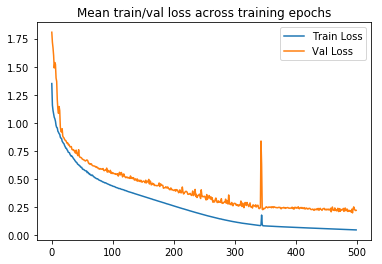

In [12]:
###Plot the loss history###
plt.title("Mean train/val loss across training epochs")
plt.plot(range(len(train_loss_history)),train_loss_history,label="Train Loss")
plt.plot(range(len(val_loss_history)),val_loss_history,label="Val Loss")
plt.legend()

INFO:tensorflow:Restoring parameters from /home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local/lenet_local_aug.ckpt


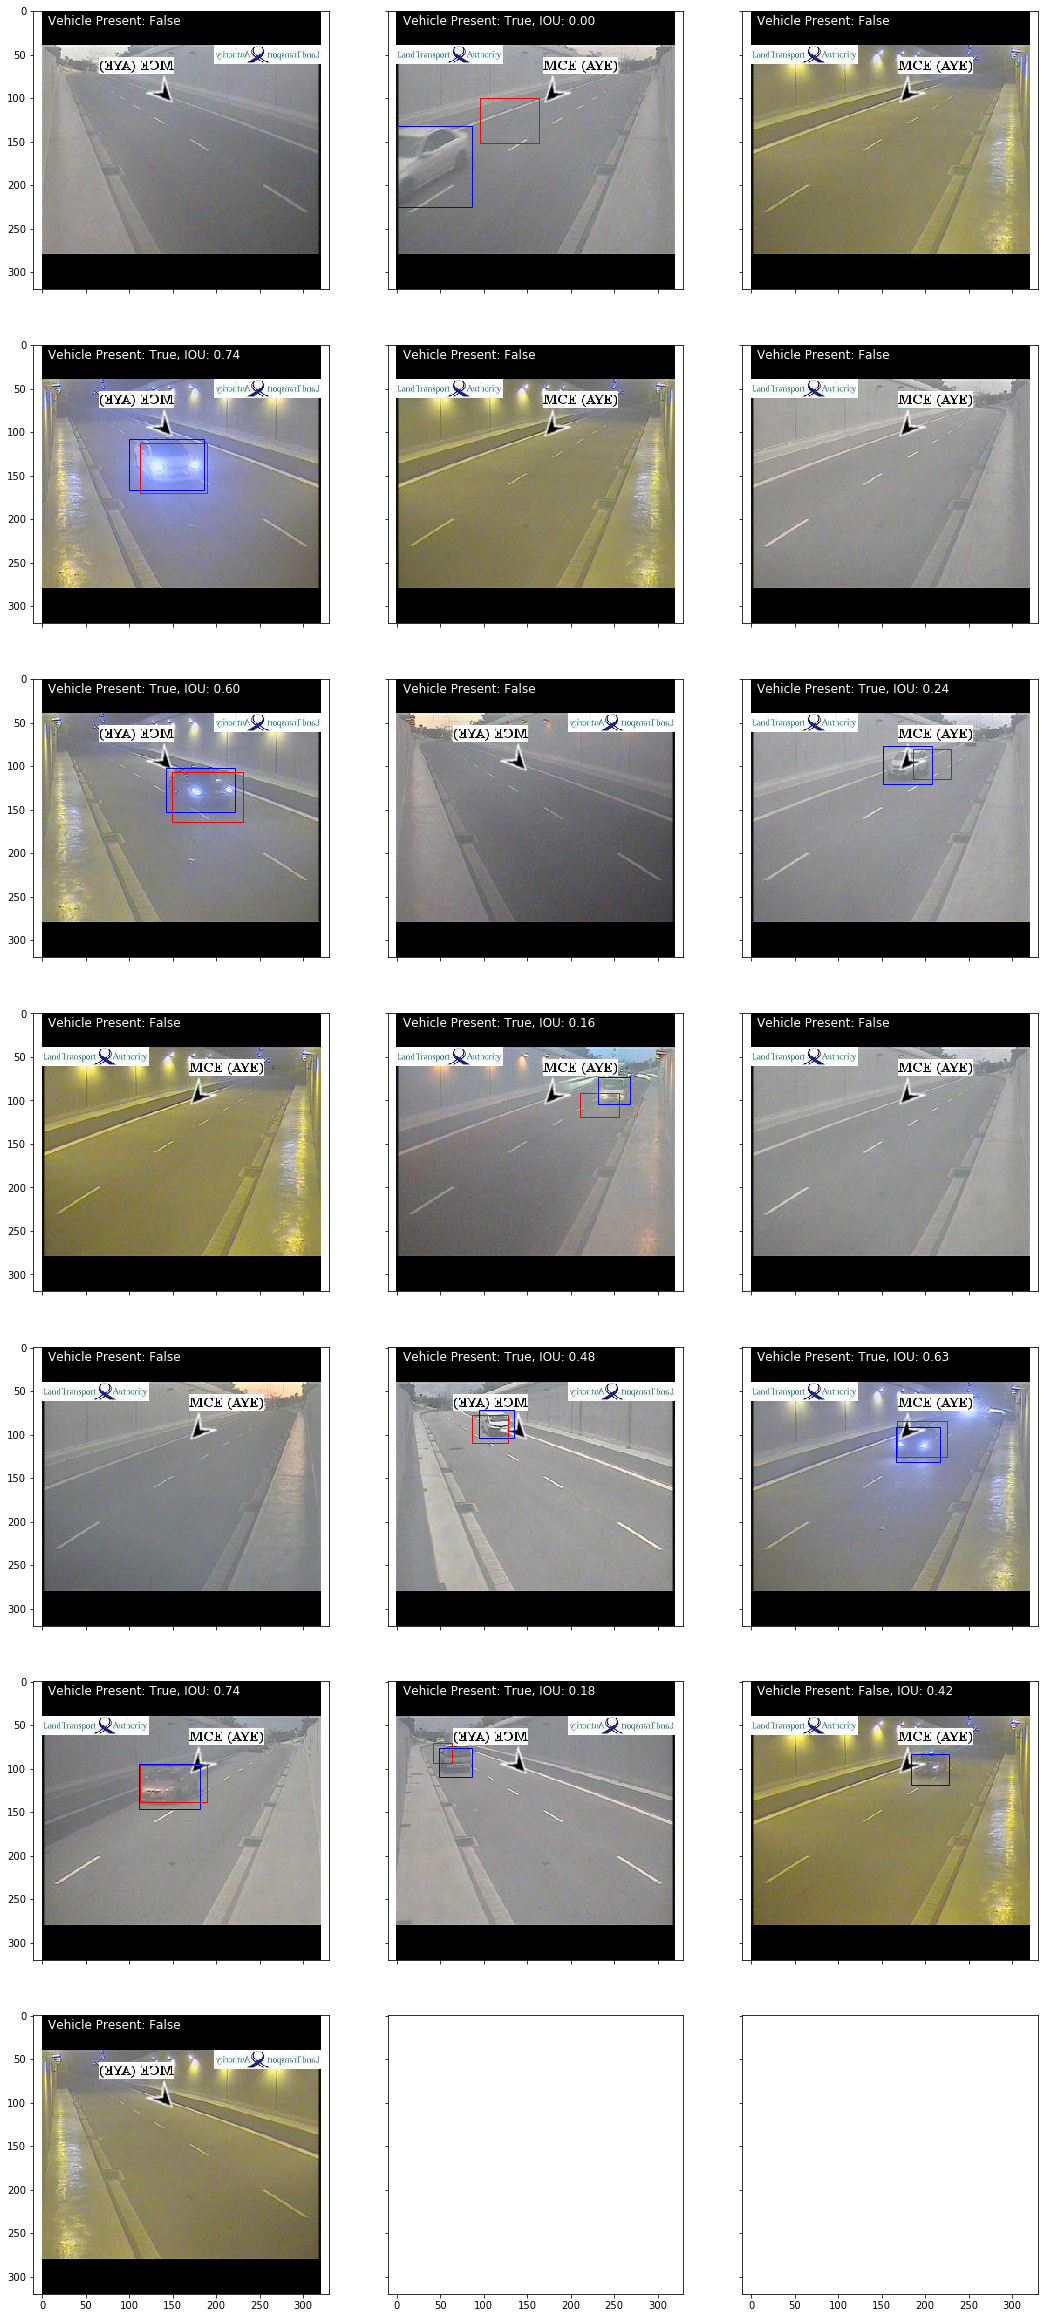

In [11]:
##Visualize some of the labels generated by the LeNet CNN
with tf.Session(graph=graph_lenet_local) as sess:
    saver.restore(sess, save_path+"/lenet_local_aug.ckpt")
    coords = val_coords.eval()
    p_labels = val_pred_labels.eval()
    plot_traffic(val_data[0:19],coords[0:19],p_label=p_labels[0:19],gt_bb=val_reg_labels[0:19],gt_label=val_labels[0:19,0])

In [17]:
###Training the LeNet Model###
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local"
os.makedirs(save_path,exist_ok=True)
start_time = time.time()

with tf.Session(graph=graph_lenet_local) as sess:
    writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
    val_loss_history = []
    train_loss_history = []
    tf.global_variables_initializer().run()
    #saver.restore(sess, save_path+"/lenet_local_aug.ckpt")
    print("Initialized!")
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        train_epoch_loss = []
        
        ##Data Augmentation (-/+ 20% adjustment on brightness/contrast)
        if augment_data:
            train_data_aug = augment(train_data,aug_max_factor,rand_order=True)
        else:
            train_data_aug = train_data
        
        ##Split into random batches and train
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data_aug[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                lr: learning_rate
            }
            t_loss,_ = sess.run([train_loss,optimizer],feed_dict=feed_dict)
            train_epoch_loss.append(t_loss)
            
        ##Calculate validation loss after each epoch
        loss = val_loss.eval()
        val_loss_history.append(loss)
        train_loss_history.append(np.mean(train_epoch_loss))
        print("Epoch {}, train_loss = {},validation loss = {}".format(num_epochs, train_loss_history[-1],loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 50 epochs
        if num_epochs%50 == 0:
            saver.save(sess, save_path+"/lenet_local_aug.ckpt")
            print("Session saved!")
        
        ##Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+"/lenet_local_aug.ckpt")

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

Initialized!
Epoch 1, train_loss = 1.4516215324401855,validation loss = 1.2921198606491089
IOU: 0.09,        Accuracy: 0.70,         AUC:0.67,         Precision: 0.64,         Recall: 0.92
Epoch 2, train_loss = 1.2583609819412231,validation loss = 1.235729694366455
IOU: 0.16,        Accuracy: 0.66,         AUC:0.67,         Precision: 0.62,         Recall: 0.81
Epoch 3, train_loss = 1.2226675748825073,validation loss = 1.2030171155929565
IOU: 0.17,        Accuracy: 0.64,         AUC:0.67,         Precision: 0.61,         Recall: 0.77
Epoch 4, train_loss = 1.1824285984039307,validation loss = 1.1760711669921875
IOU: 0.16,        Accuracy: 0.70,         AUC:0.70,         Precision: 0.64,         Recall: 0.89
Epoch 5, train_loss = 1.1547534465789795,validation loss = 1.1580719947814941
IOU: 0.18,        Accuracy: 0.70,         AUC:0.71,         Precision: 0.64,         Recall: 0.90
Epoch 6, train_loss = 1.131354808807373,validation loss = 1.13326895236969
IOU: 0.19,        Accuracy: 0.71,

IOU: 0.35,        Accuracy: 0.81,         AUC:0.92,         Precision: 0.84,         Recall: 0.76
Epoch 48, train_loss = 0.5889846086502075,validation loss = 0.6480262279510498
IOU: 0.27,        Accuracy: 0.85,         AUC:0.93,         Precision: 0.84,         Recall: 0.85
Epoch 49, train_loss = 0.5844939351081848,validation loss = 0.6333084106445312
IOU: 0.34,        Accuracy: 0.85,         AUC:0.93,         Precision: 0.84,         Recall: 0.88
Epoch 50, train_loss = 0.5787063241004944,validation loss = 0.6413828134536743
IOU: 0.34,        Accuracy: 0.83,         AUC:0.93,         Precision: 0.77,         Recall: 0.93
Session saved!
Epoch 51, train_loss = 0.5730181932449341,validation loss = 0.6322358846664429
IOU: 0.36,        Accuracy: 0.81,         AUC:0.93,         Precision: 0.87,         Recall: 0.72
Epoch 52, train_loss = 0.5664903521537781,validation loss = 0.6302562952041626
IOU: 0.34,        Accuracy: 0.82,         AUC:0.93,         Precision: 0.91,         Recall: 0.71
Ep

Epoch 94, train_loss = 0.40556204319000244,validation loss = 0.4875265061855316
IOU: 0.30,        Accuracy: 0.90,         AUC:0.97,         Precision: 0.95,         Recall: 0.83
Epoch 95, train_loss = 0.3993965983390808,validation loss = 0.47200751304626465
IOU: 0.41,        Accuracy: 0.90,         AUC:0.97,         Precision: 0.94,         Recall: 0.85
Epoch 96, train_loss = 0.39815276861190796,validation loss = 0.47516196966171265
IOU: 0.40,        Accuracy: 0.90,         AUC:0.97,         Precision: 0.94,         Recall: 0.85
Epoch 97, train_loss = 0.39517611265182495,validation loss = 0.4803333282470703
IOU: 0.36,        Accuracy: 0.90,         AUC:0.97,         Precision: 0.87,         Recall: 0.94
Epoch 98, train_loss = 0.38994911313056946,validation loss = 0.46330559253692627
IOU: 0.40,        Accuracy: 0.91,         AUC:0.97,         Precision: 0.94,         Recall: 0.87
Epoch 99, train_loss = 0.3902451992034912,validation loss = 0.46416813135147095
IOU: 0.35,        Accuracy: 

Epoch 140, train_loss = 0.3076624274253845,validation loss = 0.3977145850658417
IOU: 0.43,        Accuracy: 0.93,         AUC:0.98,         Precision: 0.91,         Recall: 0.95
Epoch 141, train_loss = 0.3070200979709625,validation loss = 0.38167881965637207
IOU: 0.38,        Accuracy: 0.94,         AUC:0.98,         Precision: 0.96,         Recall: 0.92
Epoch 142, train_loss = 0.30533742904663086,validation loss = 0.3923894166946411
IOU: 0.45,        Accuracy: 0.93,         AUC:0.98,         Precision: 0.99,         Recall: 0.86
Epoch 143, train_loss = 0.3109837770462036,validation loss = 0.37983590364456177
IOU: 0.35,        Accuracy: 0.93,         AUC:0.98,         Precision: 0.96,         Recall: 0.89
Epoch 144, train_loss = 0.30248594284057617,validation loss = 0.37261804938316345
IOU: 0.43,        Accuracy: 0.94,         AUC:0.98,         Precision: 0.96,         Recall: 0.91
Epoch 145, train_loss = 0.3019324541091919,validation loss = 0.37564796209335327
IOU: 0.32,        Accura

Epoch 186, train_loss = 0.25582951307296753,validation loss = 0.3217281997203827
IOU: 0.38,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.96,         Recall: 0.95
Epoch 187, train_loss = 0.2512037754058838,validation loss = 0.3164300322532654
IOU: 0.41,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.97,         Recall: 0.92
Epoch 188, train_loss = 0.24989816546440125,validation loss = 0.31627169251441956
IOU: 0.40,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.95,         Recall: 0.95
Epoch 189, train_loss = 0.250988245010376,validation loss = 0.3203301429748535
IOU: 0.36,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.95,         Recall: 0.95
Epoch 190, train_loss = 0.2480510175228119,validation loss = 0.31763315200805664
IOU: 0.43,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.95,         Recall: 0.95
Epoch 191, train_loss = 0.24807524681091309,validation loss = 0.3137640357017517
IOU: 0.38,        Accuracy

Epoch 232, train_loss = 0.2122809737920761,validation loss = 0.2740999460220337
IOU: 0.40,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.97,         Recall: 0.93
Epoch 233, train_loss = 0.2087029218673706,validation loss = 0.27850252389907837
IOU: 0.36,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.96,         Recall: 0.95
Epoch 234, train_loss = 0.20924237370491028,validation loss = 0.28668728470802307
IOU: 0.41,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.99,         Recall: 0.91
Epoch 235, train_loss = 0.20820358395576477,validation loss = 0.29095709323883057
IOU: 0.41,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.99,         Recall: 0.91
Epoch 236, train_loss = 0.20792385935783386,validation loss = 0.29619669914245605
IOU: 0.45,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.99,         Recall: 0.91
Epoch 237, train_loss = 0.20607596635818481,validation loss = 0.2715529799461365
IOU: 0.44,        Accu

Epoch 278, train_loss = 0.18194715678691864,validation loss = 0.258219838142395
IOU: 0.40,        Accuracy: 0.96,         AUC:0.99,         Precision: 1.00,         Recall: 0.92
Epoch 279, train_loss = 0.18039530515670776,validation loss = 0.2535741925239563
IOU: 0.44,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.98,         Recall: 0.94
Epoch 280, train_loss = 0.17772823572158813,validation loss = 0.25030210614204407
IOU: 0.44,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.98,         Recall: 0.94
Epoch 281, train_loss = 0.17904053628444672,validation loss = 0.2602669596672058
IOU: 0.43,        Accuracy: 0.96,         AUC:0.99,         Precision: 0.98,         Recall: 0.93
Epoch 282, train_loss = 0.1782558709383011,validation loss = 0.25013089179992676
IOU: 0.42,        Accuracy: 0.96,         AUC:1.00,         Precision: 0.99,         Recall: 0.93
Epoch 283, train_loss = 0.17843730747699738,validation loss = 0.2892463803291321
IOU: 0.36,        Accura

Epoch 324, train_loss = 0.15702101588249207,validation loss = 0.2323964238166809
IOU: 0.45,        Accuracy: 0.96,         AUC:1.00,         Precision: 0.99,         Recall: 0.93
Epoch 325, train_loss = 0.16094669699668884,validation loss = 0.2641502618789673
IOU: 0.42,        Accuracy: 0.96,         AUC:0.99,         Precision: 1.00,         Recall: 0.91
Epoch 326, train_loss = 0.1573738306760788,validation loss = 0.25659364461898804
IOU: 0.38,        Accuracy: 0.96,         AUC:0.99,         Precision: 1.00,         Recall: 0.92
Epoch 327, train_loss = 0.15967392921447754,validation loss = 0.23050978779792786
IOU: 0.42,        Accuracy: 0.96,         AUC:1.00,         Precision: 0.96,         Recall: 0.96
Epoch 328, train_loss = 0.16185946762561798,validation loss = 0.23030966520309448
IOU: 0.42,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.95
Epoch 329, train_loss = 0.1562204211950302,validation loss = 0.24136120080947876
IOU: 0.40,        Accu

Epoch 370, train_loss = 0.13848888874053955,validation loss = 0.22080400586128235
IOU: 0.41,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.94
Epoch 371, train_loss = 0.14045758545398712,validation loss = 0.21559464931488037
IOU: 0.39,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.95
Epoch 372, train_loss = 0.14163188636302948,validation loss = 0.23140987753868103
IOU: 0.45,        Accuracy: 0.96,         AUC:1.00,         Precision: 1.00,         Recall: 0.91
Epoch 373, train_loss = 0.13936951756477356,validation loss = 0.21486476063728333
IOU: 0.47,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.94
Epoch 374, train_loss = 0.13765574991703033,validation loss = 0.219460129737854
IOU: 0.36,        Accuracy: 0.96,         AUC:1.00,         Precision: 0.97,         Recall: 0.95
Epoch 375, train_loss = 0.13756920397281647,validation loss = 0.22972312569618225
IOU: 0.45,        Ac

Epoch 416, train_loss = 0.12482945621013641,validation loss = 0.2260476052761078
IOU: 0.41,        Accuracy: 0.96,         AUC:1.00,         Precision: 1.00,         Recall: 0.92
Epoch 417, train_loss = 0.12506458163261414,validation loss = 0.20251420140266418
IOU: 0.43,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.95
Epoch 418, train_loss = 0.12436530739068985,validation loss = 0.2037229835987091
IOU: 0.40,        Accuracy: 0.96,         AUC:1.00,         Precision: 0.99,         Recall: 0.93
Epoch 419, train_loss = 0.12368445843458176,validation loss = 0.21776941418647766
IOU: 0.38,        Accuracy: 0.97,         AUC:0.99,         Precision: 0.99,         Recall: 0.94
Epoch 420, train_loss = 0.12448328733444214,validation loss = 0.20761218667030334
IOU: 0.37,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.96,         Recall: 0.97
Epoch 421, train_loss = 0.12919165194034576,validation loss = 0.23926633596420288
IOU: 0.38,        Ac

Epoch 462, train_loss = 0.11109300702810287,validation loss = 0.19151335954666138
IOU: 0.43,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.95
Epoch 463, train_loss = 0.11076605319976807,validation loss = 0.19593322277069092
IOU: 0.45,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.95
Epoch 464, train_loss = 0.1111932098865509,validation loss = 0.2090953141450882
IOU: 0.40,        Accuracy: 0.96,         AUC:1.00,         Precision: 1.00,         Recall: 0.92
Epoch 465, train_loss = 0.10981062054634094,validation loss = 0.21135328710079193
IOU: 0.41,        Accuracy: 0.96,         AUC:1.00,         Precision: 1.00,         Recall: 0.92
Epoch 466, train_loss = 0.1116386130452156,validation loss = 0.19530615210533142
IOU: 0.41,        Accuracy: 0.97,         AUC:1.00,         Precision: 0.99,         Recall: 0.95
Epoch 467, train_loss = 0.1110331267118454,validation loss = 0.2322271466255188
IOU: 0.43,        Accur

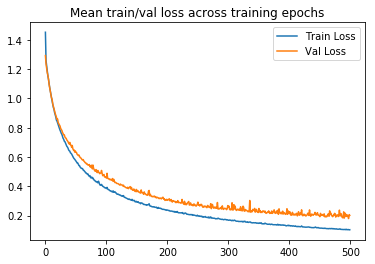

In [18]:
###Plot the loss history###
plt.title("Mean train/val loss across training epochs")
plt.plot(range(len(train_loss_history)),train_loss_history,label="Train Loss")
plt.plot(range(len(val_loss_history)),val_loss_history,label="Val Loss")
plt.legend()

INFO:tensorflow:Restoring parameters from /home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local/lenet_local.ckpt


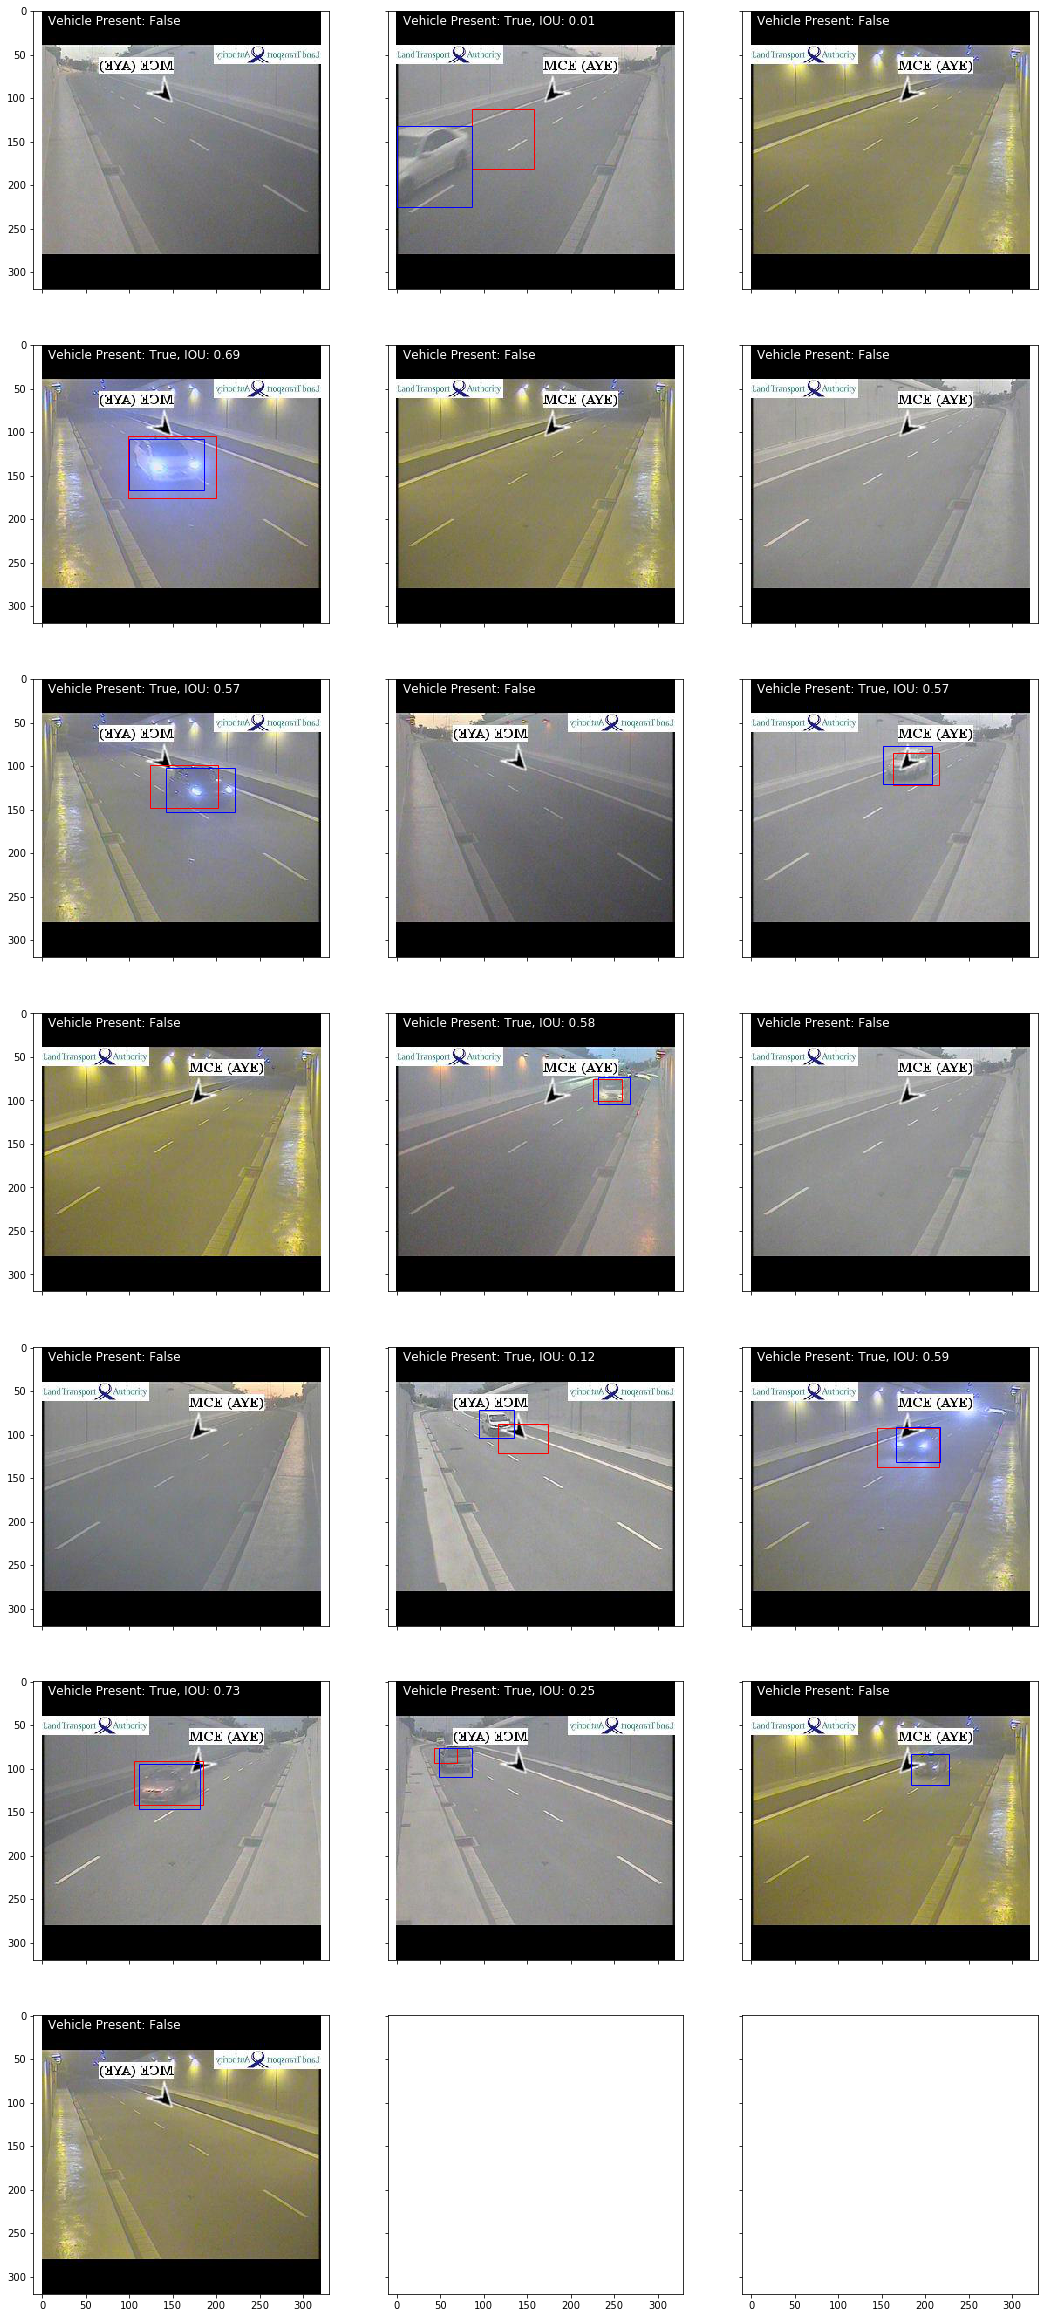

In [12]:
##Visualize some of the labels generated by the LeNet CNN
with tf.Session(graph=graph_lenet_local) as sess:
    saver.restore(sess, save_path+"/lenet_local_aug.ckpt")
    coords = val_coords.eval()
    p_labels = val_pred_labels.eval()
    plot_traffic(val_data[0:19],coords[0:19],p_label=p_labels[0:19],gt_bb=val_reg_labels[0:19],gt_label=val_labels[0:19,0])

In [9]:
##VGG16 by Visual Geometry Group, Oxford

###Parameters for VGG16###
train_epochs = 500
image_size = 320
num_channels = 3
num_reg_labels = 4
num_labels = 2
batch_size=50
conv_size=3
conv_stride=3
pool_size = 2
pool_stride = 2
depth_1=64
depth_2=128
depth_3=256
depth_4=512
depth_5=512
num_hidden_1=4096
num_hidden_2=4096
learning_rate = 1e-5
keep_prob = 0.5
regular_strength = 5e-4
augment_data = True
aug_max_factor = 0.2
#######################

graph_vgg16_local = tf.Graph()
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/vgg16_local"

with graph_vgg16_local.as_default():
    #set up variables/placeholders for tensorflow graph
    with tf.variable_scope("train_input"):
        tf_train_data = tf.placeholder(tf.float32, shape=(batch_size,image_size,image_size,num_channels),name="image_data")
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels),name="class_labels")
        tf_train_reg_labels = tf.placeholder(tf.float32, shape=(batch_size,num_reg_labels),name="bb_labels")
        lr = tf.placeholder(tf.float32,name="learning_rate")
        
    with tf.variable_scope("val_input"):
        tf_val_data = tf.constant(val_data)
        tf_val_labels = tf.constant(hot_val_labels)
        tf_val_reg_labels = tf.constant(val_reg_labels)
    
    def model(data,name,train=True):
        with tf.variable_scope(name):
            conv1 = conv2d_relu(data,conv_stride,conv_size,depth_1,name="CONV1",train=train)
            conv2 = conv2d_relu(conv1,conv_stride,conv_size,depth_1,name="CONV2",train=train)
            pool1 = max_pool(conv2,pool_size,pool_stride,name="POOL1")
            conv3 = conv2d_relu(pool1,conv_stride,conv_size,depth_2,name="CONV3",train=train)
            conv4 = conv2d_relu(conv3,conv_stride,conv_size,depth_2,name="CONV4",train=train)
            pool2 = max_pool(conv4,pool_size,pool_stride,name="POOL2")
            conv5 = conv2d_relu(pool2,conv_stride,conv_size,depth_3,name="CONV5",train=train)
            conv6 = conv2d_relu(conv5,conv_stride,conv_size,depth_3,name="CONV6",train=train)
            conv7 = conv2d_relu(conv6,conv_stride,conv_size,depth_3,name="CONV7",train=train)
            #conv8 = conv2d_relu(conv7,conv_stride,conv_size,depth_3,name="CONV8",train=train)
            pool3 = max_pool(conv7,pool_size,pool_stride,name="POOL3")
            conv9 = conv2d_relu(pool3,conv_stride,conv_size,depth_4,name="CONV9",train=train)
            conv10 = conv2d_relu(conv9,conv_stride,conv_size,depth_4,name="CONV10",train=train)
            conv11 = conv2d_relu(conv10,conv_stride,conv_size,depth_4,name="CONV11",train=train)
            #conv12 = conv2d_relu(conv11,conv_stride,conv_size,depth_4,name="CONV12",train=train)
            pool4 = max_pool(conv11,pool_size,pool_stride,name="POOL4")
            conv13 = conv2d_relu(pool4,conv_stride,conv_size,depth_5,name="CONV13",train=train)
            conv14 = conv2d_relu(conv13,conv_stride,conv_size,depth_5,name="CONV14",train=train)
            conv15 = conv2d_relu(conv14,conv_stride,conv_size,depth_5,name="CONV15",train=train)
            #conv16 = conv2d_relu(conv15,conv_stride,conv_size,depth_5,name="CONV16",train=train)
            pool5 = max_pool(conv15,pool_size,pool_stride,name="POOL5")
            ##Implement dropout on the fully connected layers
            if train:
                fc1_class = tf.nn.dropout(fully_connected(pool5,num_hidden_1,name="FC1_class",train=train,xv=False),keep_prob)
                fc2_class = tf.nn.dropout(fully_connected(fc1_class,num_hidden_2,name="FC2_class",train=train),keep_prob)
                fc1_reg = tf.nn.dropout(fully_connected(pool5,num_hidden_1,name="FC1_reg",train=train,xv=False),keep_prob)
            else:
                fc1_class = fully_connected(pool5,num_hidden_1,name="FC1_class",train=train)
                fc2_class = fully_connected(fc1_class,num_hidden_2,name="FC2_class",train=train)
                fc1_reg = fully_connected(pool5,num_hidden_1,name="FC1_reg",train=train)
            ##For stability of training, intentionally exclude dropout on layer before regression output layer
            fc2_reg = fully_connected(fc1_reg,num_hidden_2,name="FC2_reg",train=train)
            ##Calculate outputs for classification and localization
            output_logits = fully_connected(fc2_class,num_labels,name="Output_logits",train=train)
            output_coords = fully_connected(fc2_reg,num_reg_labels,activation=False,name="Output_coords",train=train)
        return output_logits, output_coords
    
    def loss(reg_pred,reg_label,class_logit,class_label,name):
        with tf.variable_scope(name):
            with tf.variable_scope("Regression_Loss"):
                mask = tf.equal(class_label[:,1], tf.ones_like(class_label[:,1]))
                with tf.variable_scope("Coord_Loss"):
                    coord_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,0:2],mask)-tf.boolean_mask(reg_pred[:,0:2],mask)),1))
                with tf.variable_scope("Box_Loss"):
                    box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,2:],mask)-tf.boolean_mask(reg_pred[:,2:],mask)),1))
                regression_loss = coord_loss + box_loss
            with tf.variable_scope("Class_Loss"):
                class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=class_label,logits=class_logit))
            with tf.variable_scope("Regularization_Loss"):
                g = tf.get_default_graph()
                regular_loss = (tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_class/weights:0"))+ 
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC2_class/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_logits/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_reg/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC2_reg/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_coords/weights:0")))
            loss = class_loss+regression_loss+(regular_strength*regular_loss)
        return loss
    
    train_logits, train_coords = model(tf_train_data,"Train_Model",train=True)
    val_logits, val_coords = model(tf_val_data,"Val_Model",train=False)
        
    train_loss = loss(train_coords,tf_train_reg_labels,train_logits,tf_train_labels,"Train_Loss")
    val_loss = loss(val_coords,tf_val_reg_labels,val_logits,tf_val_labels,"Val_Loss")
    
    with tf.variable_scope("Val_Pred_Labels"):
        val_pred_logits = tf.nn.softmax(val_logits)
        val_pred_labels = tf.argmax(val_pred_logits,axis=1)
    
    with tf.variable_scope("Train"):
        train_model = tf.train.AdamOptimizer(lr).minimize(train_loss)
        
    with tf.variable_scope("Saver"):
        saver = tf.train.Saver()
        
print("Tensorflow graph created!")

Tensorflow graph created!


In [ ]:
###Training the VGG16 Model###
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/vgg16_local"
os.makedirs(save_path,exist_ok=True)
start_time = time.time()

with tf.Session(graph=graph_vgg16_local) as sess:
    #writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
    val_loss_history = []
    train_loss_history = []
    #tf.global_variables_initializer().run()
    saver.restore(sess, save_path+"/vgg16_local_aug.ckpt")
    print("Initialized!")
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        train_epoch_loss = []
        
        ##Data Augmentation (-/+ 20% adjustment on brightness/contrast)
        if augment_data:
            train_data_aug = augment(train_data,aug_max_factor,rand_order=True)
        else:
            train_data_aug = train_data
        
        ##Feed randomized batch for training
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data_aug[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                lr: learning_rate
            }
            t_loss, _ = sess.run([train_loss,train_model],feed_dict=feed_dict)
            train_epoch_loss.append(t_loss)
            
        loss = val_loss.eval()
        val_loss_history.append(loss)
        train_loss_history.append(np.mean(train_epoch_loss))
        print("Epoch {}, training loss= {}, validation loss = {}".format(num_epochs,train_loss_history[-1],loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 50 epochs
        if num_epochs%50 == 0:
            saver.save(sess, save_path+"/vgg16_local_aug.ckpt")
            print("Session saved!")
        
        ###Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+"/vgg16_local_aug.ckpt")

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

INFO:tensorflow:Restoring parameters from /home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/vgg16_local/vgg16_local_aug.ckpt
Initialized!
Epoch 1, training loss= 0.05511663109064102, validation loss = 0.3635973036289215
IOU: 0.29,        Accuracy: 0.93,         AUC:0.99,         Precision: 0.94,         Recall: 0.91
Epoch 2, training loss= 0.05674442648887634, validation loss = 0.41377943754196167
IOU: 0.32,        Accuracy: 0.92,         AUC:0.99,         Precision: 0.87,         Recall: 0.98
Epoch 3, training loss= 0.052446939051151276, validation loss = 0.32293424010276794
IOU: 0.24,        Accuracy: 0.93,         AUC:0.99,         Precision: 0.91,         Recall: 0.94
Epoch 4, training loss= 0.049357302486896515, validation loss = 0.2715030312538147
IOU: 0.30,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.93,         Recall: 0.95
Epoch 5, training loss= 0.05170213431119919, validation loss = 0.30531740188598633
IOU: 0.30,        Accuracy: 0.94

Epoch 46, training loss= 0.04613533243536949, validation loss = 0.36497044563293457
IOU: 0.33,        Accuracy: 0.94,         AUC:0.98,         Precision: 0.94,         Recall: 0.93
Epoch 47, training loss= 0.045503340661525726, validation loss = 0.3159463405609131
IOU: 0.27,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.93,         Recall: 0.96
Epoch 48, training loss= 0.04427329823374748, validation loss = 0.30459803342819214
IOU: 0.30,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.94,         Recall: 0.94
Epoch 49, training loss= 0.04724220186471939, validation loss = 0.2840525805950165
IOU: 0.31,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.95,         Recall: 0.93
Epoch 50, training loss= 0.05383636802434921, validation loss = 0.38380467891693115
IOU: 0.31,        Accuracy: 0.93,         AUC:0.98,         Precision: 0.96,         Recall: 0.90
Session saved!
Epoch 51, training loss= 0.060593828558921814, validation loss = 0.302229553

Epoch 91, training loss= 0.04248752444982529, validation loss = 0.2824574112892151
IOU: 0.34,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.94,         Recall: 0.95
Epoch 92, training loss= 0.046650633215904236, validation loss = 0.3018997609615326
IOU: 0.36,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.92,         Recall: 0.96
Epoch 93, training loss= 0.03947112709283829, validation loss = 0.3207262456417084
IOU: 0.35,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.94,         Recall: 0.93
Epoch 94, training loss= 0.04177466034889221, validation loss = 0.32256752252578735
IOU: 0.37,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.94,         Recall: 0.92
Epoch 95, training loss= 0.043087854981422424, validation loss = 0.3496009409427643
IOU: 0.34,        Accuracy: 0.94,         AUC:0.98,         Precision: 0.91,         Recall: 0.96
Epoch 96, training loss= 0.04213567450642586, validation loss = 0.418783962726593
IOU: 0.32,

Epoch 136, training loss= 0.03976104408502579, validation loss = 0.35983121395111084
IOU: 0.35,        Accuracy: 0.93,         AUC:0.98,         Precision: 0.95,         Recall: 0.90
Epoch 137, training loss= 0.03485478460788727, validation loss = 0.28723227977752686
IOU: 0.34,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.94,         Recall: 0.93
Epoch 138, training loss= 0.03784363716840744, validation loss = 0.2282446026802063
IOU: 0.35,        Accuracy: 0.95,         AUC:0.99,         Precision: 0.96,         Recall: 0.94
Epoch 139, training loss= 0.038923487067222595, validation loss = 0.25049442052841187
IOU: 0.32,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.96,         Recall: 0.92
Epoch 140, training loss= 0.03408147022128105, validation loss = 0.24850532412528992
IOU: 0.34,        Accuracy: 0.94,         AUC:0.99,         Precision: 0.96,         Recall: 0.91
Epoch 141, training loss= 0.03412298858165741, validation loss = 0.23041895031929016


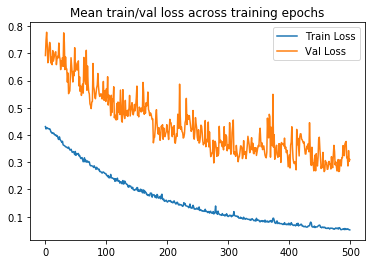

In [12]:
###Plot the loss history###
plt.title("Mean train/val loss across training epochs")
plt.plot(range(len(train_loss_history)),train_loss_history,label="Train Loss")
plt.plot(range(len(val_loss_history)),val_loss_history,label="Val Loss")
plt.legend()

In [91]:
###Training the VGG16 Model###
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/vgg16_local"
os.makedirs(save_path,exist_ok=True)
start_time = time.time()

with tf.Session(graph=graph_vgg16_local) as sess:
    writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
    #loss_history = []
    #tf.global_variables_initializer().run()
    saver.restore(sess, save_path+"/vgg16_local.ckpt")
    print("Initialized!")
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        t_losses = []
        ##Feed randomized batch for training
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                lr: learning_rate
            }
            t_loss, _ = sess.run([train_loss,optimizer],feed_dict=feed_dict)
            t_losses.append(t_loss)
            
        loss = val_loss.eval()
        loss_history.append(loss)
        print("Epoch {}, training loss= {}, validation loss = {}".format(num_epochs,np.mean(t_losses),loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 50 epochs
        if num_epochs%50 == 0:
            saver.save(sess, save_path+"/vgg16_local.ckpt")
            print("Session saved!")
        
        ###Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+"/vgg16_local.ckpt")

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

INFO:tensorflow:Restoring parameters from working_data/saved_models/vgg16_local/vgg16_local.ckpt
Initialized!
Epoch 1, training loss= 0.006745029706507921, validation loss = 0.1383046954870224
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 2, training loss= 0.006730793975293636, validation loss = 0.13804158568382263
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 3, training loss= 0.006597868632525206, validation loss = 0.13768668472766876
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 4, training loss= 0.006695035845041275, validation loss = 0.13756301999092102
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 5, training loss= 0.0065233949571847916, validation loss = 0.13688981533050537
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 6, training loss= 0.006528023164719343, validation loss = 0.13725772500038147
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.9

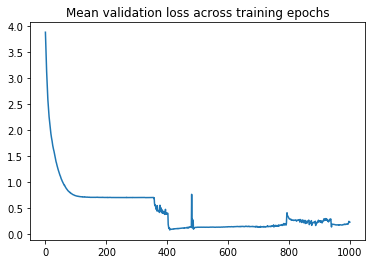

In [92]:
###Plot the loss history###
plt.title("Mean validation loss across training epochs")
plt.plot(range(len(loss_history)),loss_history)

INFO:tensorflow:Restoring parameters from working_data/saved_models/vgg16_local/vgg16_local.ckpt


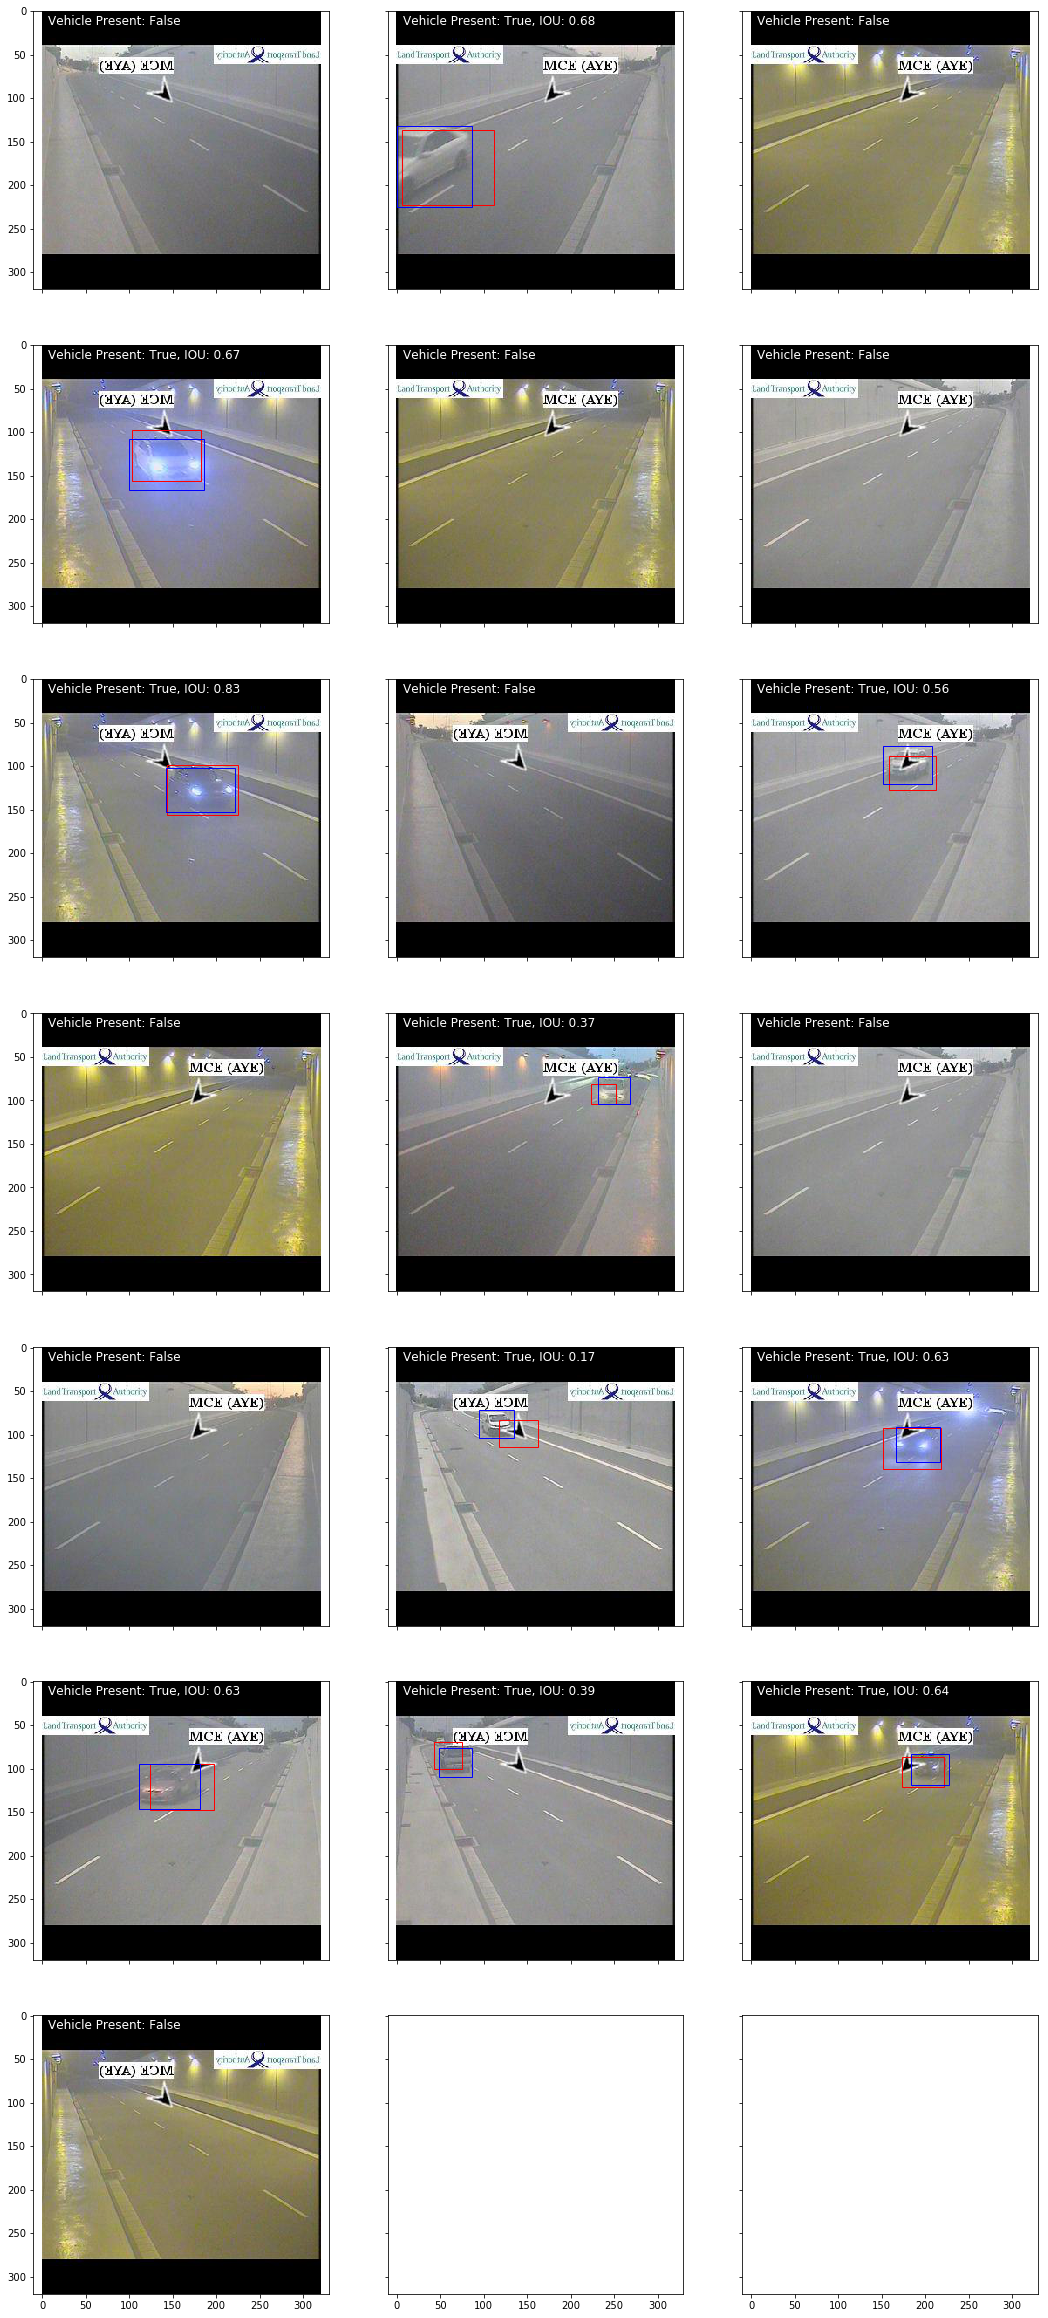

In [94]:
with tf.Session(graph=graph_vgg16_local) as sess:
    saver.restore(sess, save_path+"/vgg16_local.ckpt")
    coords = val_coords.eval()
    p_labels = val_pred_labels.eval()
    plot_traffic(val_data[0:19],coords[0:19],p_label=p_labels[0:19],gt_bb=val_reg_labels[0:19],gt_label=val_labels[0:19,0])

### Assessing performance of localization head

In previous classification notebook, assessing performance of a classfier was done via observing the Accuracy, AUC, precision/recall metrics on the validation set.

For the localization problem, we have to use a new metric to assess performance of the classfier, namely Intersection Over Union (IOU). As its name suggests, it is simply the ratio of the intersection and union of the ground truth bounding box vs the predicted bounding box. A perfect score would be = 1.

In [69]:
#Function to implement the IOU metric
def IOU(bounding_true,bounding_pred):
    if bounding_pred.ndim == 1:
        bounding_pred = np.reshape(bounding_pred,[1,-1])
    if bounding_true.ndim == 1:
        bounding_true = np.reshape(bounding_true,[1,-1])
    int_deltaX = np.minimum(bounding_true[:,2],bounding_pred[:,2])-np.maximum(bounding_true[:,0],bounding_pred[:,0])
    int_deltaY = np.minimum(bounding_true[:,3],bounding_pred[:,3])-np.maximum(bounding_true[:,1],bounding_pred[:,1])
    int_area = np.maximum(int_deltaX*int_deltaY,0)
    true_area = (bounding_true[:,2]-bounding_true[:,0])*(bounding_true[:,3]-bounding_true[:,1])
    pred_area = (bounding_pred[:,2]-bounding_pred[:,0])*(bounding_pred[:,3]-bounding_pred[:,1])
    union_area = true_area+pred_area-int_area
    iou = int_area/union_area
    return np.mean(iou)

In [42]:
time_now = datetime.datetime.now()
data= load_one_image(1504,time_now)

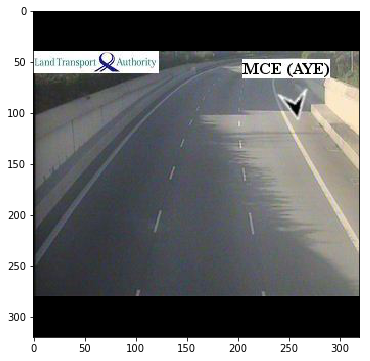

In [43]:
plot_traffic(data)